In [1]:
# Enable auto-reload of modified python files.
%load_ext autoreload
%autoreload 2

# imports
import warnings
import settings
import pandas as pd
import numpy as np
from scipy import stats
from scipy.spatial import distance
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

warnings.filterwarnings('ignore')

C:\Users\ehall\Anaconda3\envs\beppy\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ehall\Anaconda3\envs\beppy\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\ehall\Anaconda3\envs\beppy\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
### stats of memory for target and non-target objects by condition
df = pd.read_csv(settings.DATA_PATH + '/drawings.csv')
search = df[df['condition'] == 'search']
memorize = df[df['condition'] == 'memorize']
search["matched"] = np.where(search['average']>.65, 1, 0)
memorize["matched"] = np.where(memorize['average']>.65, 1, 0)
grouped_search = search.groupby(['image_name', 'identity']).mean().reset_index()
grouped_mem = memorize.groupby(["image_name", 'identity']).mean() .reset_index()
search_target = grouped_search[grouped_search['identity']=='target']
mem_target = grouped_mem[grouped_mem['identity']=='target']
search_non = grouped_search[grouped_search['identity']=='nonspecific']
mem_non = grouped_mem[grouped_mem['identity']=='nonspecific']

print('TARGET STATS:')
print('search mean:', search_target.matched.mean())
print('search std:', search_target.matched.std())
print('mem mean:', mem_target.matched.mean())
print('mem std:', mem_target.matched.std())
print('ranks sums by image', stats.ranksums(search_target['matched'], mem_target['matched']))

print('NONSPECIFIC STATS:')
print('search mean:', search_non.matched.mean())
print('search std:', search_non.matched.std())
print('mem mean:', mem_non.matched.mean())
print('mem std:', mem_non.matched.std())
print('rank sums by image', stats.ranksums(search_non['matched'], mem_non['matched']))

TARGET STATS:
search mean: 0.8036261150772781
search std: 0.1608925554529607
mem mean: 0.19529814956285546
mem std: 0.18806223021715757
ranks sums by image RanksumsResult(statistic=4.500370355130046, pvalue=6.783516788914353e-06)
NONSPECIFIC STATS:
search mean: 0.2090366702475672
search std: 0.0937349247301745
mem mean: 0.30159747172031964
mem std: 0.13755829278038417
rank sums by image RanksumsResult(statistic=-2.5509011690368464, pvalue=0.010744478934428568)


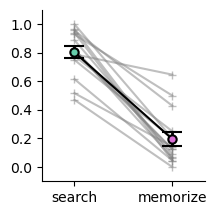

In [3]:
# plot memory for target objects by condition
search_target['condition'] = 'search'
mem_target['condition'] ='memorize'
plotdf = pd.concat([search_target, mem_target])
plotdf['image'] = plotdf['image_name']
plotdf = plotdf.sort_values(by=['condition', 'image'], ascending=False)
fig, ax = plt.subplots(figsize=(2.25,2.25))
x = [0,.3]
y = [plotdf[plotdf["condition"]=="search"]["matched"].mean(),plotdf[plotdf["condition"]=="memorize"]["matched"].mean()]
error = [stats.sem(plotdf[plotdf["condition"]=="search"]["matched"]), stats.sem(plotdf[plotdf["condition"]=="memorize"]["matched"])]
for currim in plotdf.image.unique():
    currdf = plotdf.loc[plotdf['image']== currim]
    ax.plot(x, currdf['matched'], linestyle="-",marker='+', markersize=6,markeredgewidth=1,  color='gray', 
             markeredgecolor="gray",  alpha=.5,linewidth=1.5,  markerfacecolor='none')
plt.plot([0,.3],[y[0],y[1]],linestyle="-",  color='black' )
plt.errorbar(0, y[0],
             yerr = error[0],  fmt='o', color='mediumaquamarine', 
           markersize=6,capsize=7, markeredgecolor='black',
             elinewidth=2, markeredgewidth=1.5, ecolor='black')
plt.errorbar(.3, y[1],
             yerr = error[1],  fmt='o', color='orchid', 
             markersize=6,capsize=7, markeredgecolor='black',
             elinewidth=2, markeredgewidth=1.5, ecolor='black')
ax.set_xticks([0,.3], labels=['search','memorize'])
ax.set_xlim([-.1, .4])
ax.set_yticks([0, 0.2, 0.4, 0.6,0.8, 1.0])
ax.set_ylim([-0.1,1.1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig(settings.RESULTS_PATH + '/figure6/6b.svg', dpi=1000)

In [4]:
# calculate object size, prox to center, and prox to target 
img_data = pd.read_csv(settings.DATA_PATH + '/locations.csv')
target_info = img_data.loc[img_data["identity"] == 'target']
center = (640, 480)
dist_to_target = []
dist_to_center = []

for ind, row in df.iterrows():
    curr_target = target_info.loc[target_info["image_name"] == row["image_name"]]
    dist_to_target.append(distance.euclidean((int(curr_target['img_cx']),int(curr_target['img_cy'])),
                                       (row["img_cx"], row["img_cy"])))
    dist_to_center.append(distance.euclidean(center,(row["img_cx"], row["img_cy"])))
df["prox_to_target"] = [i * -1 for i in dist_to_target]
df["prox_to_center"] = [i * -1 for i in dist_to_center]
df["size"] = df["img_rx"] * df["img_ry"] * math.pi

In [5]:
# stats for proximity to target
search_df = df[df['condition']=='search']
search_df = search_df[search_df['identity'] != 'target']
search_df['z_prox_to_target'] = stats.zscore(search_df['prox_to_target'])
log_reg = smf.logit("matched ~ z_prox_to_target", 
                    data=search_df).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.471787
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                matched   No. Observations:                 6165
Model:                          Logit   Df Residuals:                     6163
Method:                           MLE   Df Model:                            1
Date:                Fri, 03 May 2024   Pseudo R-squ.:                0.001921
Time:                        13:07:11   Log-Likelihood:                -2908.6
converged:                       True   LL-Null:                       -2914.2
Covariance Type:            nonrobust   LLR p-value:                 0.0008204
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.5146      0.033    -45.610      0.000      -1.580      -1.449
z_prox_to_t

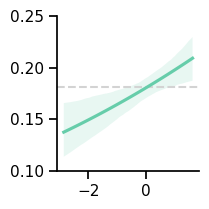

In [6]:
# plot for prox to target
sns.set_context("notebook",  font_scale=1)
fig, ax = plt.subplots(figsize=(2.25,2.25))

ax = sns.regplot(x='z_prox_to_target', y = 'matched', 
           data=search_df, logistic=True, scatter=False,
            scatter_kws={'color': 'black'}, line_kws={'color': 'mediumaquamarine'})
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim(0.10,.25)
plt.axhline(y = search_df['matched'].mean(), color = 'lightgray', linestyle = '--', zorder=1)
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
plt.savefig(settings.RESULTS_PATH + '/figure6/6c.svg', dpi=1000)


In [7]:
# stats for proximity to image center
mem_df = df[df['condition']=='memorize']
mem_df['z_prox_to_center'] =stats.zscore(mem_df['prox_to_center'])
mem_df['z_prox_to_target'] =stats.zscore(mem_df['prox_to_target'])

log_reg = smf.logit("matched ~ z_prox_to_center + z_prox_to_target", 
                    data=mem_df).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.603353
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                matched   No. Observations:                 5782
Model:                          Logit   Df Residuals:                     5779
Method:                           MLE   Df Model:                            2
Date:                Fri, 03 May 2024   Pseudo R-squ.:                0.008072
Time:                        13:07:22   Log-Likelihood:                -3488.6
converged:                       True   LL-Null:                       -3517.0
Covariance Type:            nonrobust   LLR p-value:                 4.693e-13
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.8718      0.029    -30.014      0.000      -0.929      -0.815
z_prox_to_c

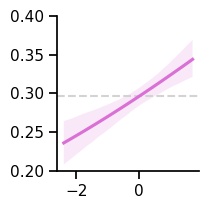

In [8]:
# plot for proximity to image center
sns.set_context("notebook",  font_scale=1)
fig, ax = plt.subplots(figsize=(2.25,2.25))

ax = sns.regplot(x='z_prox_to_center', y = 'matched', 
           data=mem_df, logistic=True, scatter=False,
            scatter_kws={'color': 'black'}, line_kws={'color': 'orchid'})
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylim(0.20,.4)
plt.axhline(y = mem_df['matched'].mean(), color = 'lightgray', linestyle = '--', zorder=1)
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
plt.savefig(settings.RESULTS_PATH + '/figure6/6d.svg', dpi=1000)

In [9]:
# stats for probability of recall by object size 
df['zscore_size'] = stats.zscore(df['size'])
log_reg = smf.logit("matched ~ zscore_size * C(condition)", 
                    data=df).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.535053
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                matched   No. Observations:                12230
Model:                          Logit   Df Residuals:                    12226
Method:                           MLE   Df Model:                            3
Date:                Fri, 03 May 2024   Pseudo R-squ.:                 0.04814
Time:                        13:07:34   Log-Likelihood:                -6543.7
converged:                       True   LL-Null:                       -6874.6
Covariance Type:            nonrobust   LLR p-value:                3.983e-143
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -0.8685      0.029    

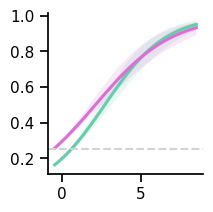

In [10]:
# plot for probability of recall object size 
sns.set_context("notebook",  font_scale=1)
sns.lmplot(x='zscore_size', y = 'matched', hue='condition', legend=False, 
           scatter=False, height=2.5, aspect=1,
           data=df, logistic=True, 
           palette=['mediumaquamarine', 'orchid'])
plt.axhline(y = df['matched'].mean(), color = 'lightgray', linestyle = '--')
plt.xlabel('')
plt.ylabel('')
plt.savefig(settings.RESULTS_PATH + '/figure6/6e.svg', dpi=1000)